# Trial matrix processing

We calculate some scores that characterise the trial matrices, including the matrix correlation and its significance.

To detect cells with significant effect of lever position, we calculate the correlation between the firing peak position (y-coordinate) and the lever position (y-coordinate) and its significance.


## Load the data

In [2]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:21<00:00,  1.82it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [4]:
# matrices with single trials 
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    searchIFR = pickle.load(handle)
    
# matrices with single trials 
fn=myProject.dataPath+"/results/homingIFRDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    homingIFR = pickle.load(handle)

loading: /adata/projects/autopi_ca1/results/searchIFRDict.pickle
loading: /adata/projects/autopi_ca1/results/homingIFRDict.pickle


Because it takes time to run these analysis, we will limit it to the pyramidal cells for now.

In [5]:
fn=myProject.dataPath+"/results/cell_classification.csv"
ct = pd.read_csv(fn)
pyrIndices=ct.cellType=="pyr"
pyrId=ct.id[ct.cellType=="pyr"]
print("Pyramidal cells: {}".format(np.sum(ct.cellType=="pyr")))
print("Pyramidal cells: {}".format(np.sum(pyrIndices)))

Pyramidal cells: 438
Pyramidal cells: 438


In [6]:
mySearchDict={}
for oneId in searchIFR.keys():
    if oneId in list(pyrId):
        mySearchDict.update({oneId:searchIFR[oneId]})
print(len(mySearchDict.keys()))

myHomingDict={}
for oneId in homingIFR.keys():
    if oneId in list(pyrId):
        myHomingDict.update({oneId:homingIFR[oneId]})
print(len(myHomingDict.keys()))

438
438


The `mySearchDict` contains several nested dictionaries. 

* cluId
* matrix
* searchToLeverPath_light_y
* matrix


In [5]:
myHomingDict['mn711-01022021-0107_41']["matrix"]['homingFromLeavingLeverToPeriphery_dark_distance'].keys()

dict_keys(['matrix', 'bins', 'names'])

In [6]:
myHomingDict['mn711-01022021-0107_41']["matrix"].keys()

dict_keys(['homingFromLeavingLeverToPeriphery_light_iTime', 'homingFromLeavingLeverToPeriphery_dark_iTime', 'homingFromLeavingLeverToPeriphery_light_distance', 'homingFromLeavingLeverToPeriphery_dark_distance', 'homingFromLeavingLeverToPeriphery_light_targetDistance', 'homingFromLeavingLeverToPeriphery_dark_targetDistance', 'homingFromLeavingLeverToPeriphery_light_y', 'homingFromLeavingLeverToPeriphery_dark_y'])

## Characterization of the trial matrix

For each matrix, we want to extract information that we can used to describe the firing fields of the neuron.



Let's find some examples to work with.

In [7]:
list(mySearchDict.keys())[40:45]

['mn711-01022021-0107_41',
 'mn711-01022021-0107_69',
 'mn711-01022021-0107_75',
 'mn711-01022021-0107_81',
 'mn711-01022021-0107_83']

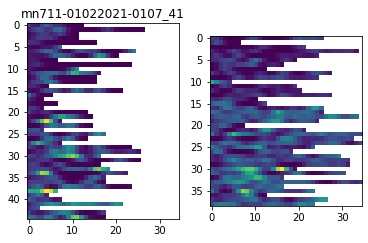

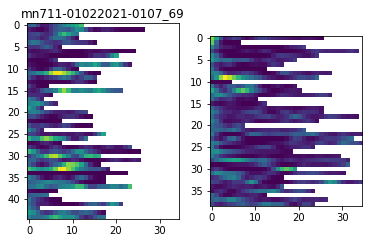

In [8]:
for k in list(mySearchDict.keys())[40:42]:
    ml = mySearchDict[k]["matrix"]["searchToLeverPath_light_y"]["matrix"].copy()
    md = mySearchDict[k]["matrix"]["searchToLeverPath_dark_y"]["matrix"].copy()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(ml,interpolation="none")
    ax[0].set_title(k)
    ax[1].imshow(md,interpolation="none")
    plt.show()


mn711-01022021-0107_41


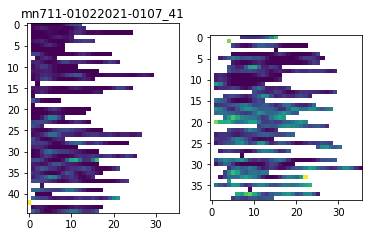

mn711-01022021-0107_69


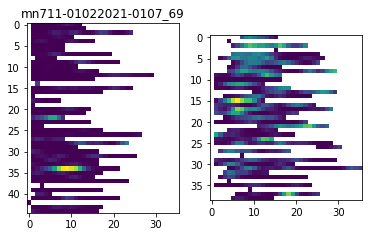

In [9]:
for k in list(myHomingDict.keys())[40:42]:
    print(k)
    ml = myHomingDict[k]["matrix"]["homingFromLeavingLeverToPeriphery_light_y"]["matrix"].copy()
    md = myHomingDict[k]["matrix"]["homingFromLeavingLeverToPeriphery_dark_y"]["matrix"].copy()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(ml,interpolation="none")
    ax[0].set_title(k)
    ax[1].imshow(md,interpolation="none")
    plt.show()

We want a function to plot the trial matrix. The function will take a dictionary with the keys `matrix` and `bins`.

In [10]:
def plotTrialIFRMatrix(ax,matDict,showXLabel=True,sort=False, showYLabel=True,colorBar=False,aspect="auto"):
    """
    Plot the matrix of rate per journey as a function ?
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    xLabelsDict = {"y":"y coordinates (cm)",
                   "iTime": "Time (sec)",
                   "distance": "Distance run (cm)",
                   "targetDistance": "Lever distance (cm)"}
    
    # sort matrix from shortest to longest distance from lever
    if sort:
        m= m[np.argsort(-np.sum(np.isnan(m),axis=1))].copy()
    
    pos = ax.imshow(m,aspect=aspect,interpolation="none",origin="lower",cmap="jet",
                   extent=[np.min(bins),np.max(bins),0,m.shape[0]])
    if colorBar:
        fig.colorbar(pos, ax=ax)
    
    if showYLabel:
        ax.set_ylabel("Paths")
    if showXLabel:
        ax.set_xlabel(xLabelsDict[matDict["var"]])
        ax.xaxis.set_label_coords(0.5,-0.175)
    else:
        ax.set_xlabel(xLabel)
    #ax.yaxis.set_label_coords(-0.4, 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

We need to process the trial matrix to get valid stats. 
We get rid of empty columns after the last column with valid data.
We also trim super long trial so that we have a minimum of 4 valid data firing rate to get the mean rate of each column

In [11]:
def trimTrailingMatrixNanColumn(matDict):
    """
    Removes columns of the matrix that are filled with np.nan. 
    Only removes columns that are after the last column containing valid values
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    nRows = m.shape[0]
    nCols = m.shape[1]
    emptyCol = np.sum(np.isnan(m),axis=0) == nRows
    if np.sum(emptyCol) > 0:
        lastNotEmpty = np.max(np.where(emptyCol==0))
        m = m[:,:lastNotEmpty+1]
        bins = bins[:lastNotEmpty+2]
    
    matDict["matrix"] = m
    matDict["bins"] = bins
    
    #print("trim",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict
    
def removeEmptyTrials(matDict):
    """
    Remove any trials that have only np.nan values
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    matDict["matrix"] = m[np.sum(~np.isnan(m),axis=1)>0,:]
    #print("removeEmpyt",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict
    
    
def cutExtremelyLongTrials(matDict, minNumberValidValues=10):
    """
    Identify the longest trials of the session and remove the values at the end so that there is at least minNumberValidValues in each column of the matrix
    
    This was implemented to prevent that a single very long trial compromise the detection of the peak firing rate location calculated from all trials. 
    
    This procedure makes sure that one spike in a very long path will not be detected as the peak location in the matrix. Each value will be the average of a few trials.
    
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    def myFct(x):
        if np.sum(x)> 0:
            return np.max(np.where(x))
        else:
            return x.shape[0]
    lastValidValueInRow = np.apply_along_axis(myFct, axis=1,arr = ~np.isnan(m))
    sortedValid = np.sort(lastValidValueInRow)
    threshold = sortedValid[-minNumberValidValues]
    
    matDict["matrix"] = m[:,:threshold+1]
    matDict["bins"] = bins[:threshold+2]
    #print("cutExtremelyLong",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict

In [12]:
def removeEmptyColumnsAtBeginning(matDict,minNumberValidValues=10):
    """
    Check if there are empty columns at the left side of the matrix or if there are some that have fewer than minNumberValidValues, if so remove them.
    
    It will stop removing as soon as there is a column with the minNumberValidValues
    
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    def myFct(x):
        if np.sum(x)>0:
            return np.min(np.where(x))
        else:
            return 0
    firstValidValueInRow = np.apply_along_axis(myFct, axis=1,arr = ~np.isnan(m))
    
    sortedValid = np.sort(firstValidValueInRow)
    threshold = sortedValid[minNumberValidValues]
    
    matDict["matrix"] = m[:,threshold:]
    matDict["bins"] = bins[(threshold):]
    #print("removeEmptyColumns",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict

We can get the matrix and bins from the dictionary containing all matrices. 

In [13]:
def get_matDic(mainDict,cluId,pathType,light,var):
    """
    get a dictionary with one matrix, bins, and other variables from the dictionary containing all neurons, all conditions
    
    We set a few keys in the dictionary that can be used when ploting and processing.
    """
    matDic = mainDict[cluId]["matrix"]["{}_{}_{}".format(pathType,light,var)]
    matDic["pathType"] = pathType
    matDic["light"] = light
    matDic["var"] = var
    matDic["cluId"] = cluId
    return matDic

In [14]:
m1 = get_matDic(myHomingDict,cluId="mn3246-09042021-0106_4",pathType = "homingFromLeavingLeverToPeriphery", light = "light", var = "y")
m2 = get_matDic(myHomingDict,cluId='mn711-01022021-0107_41',pathType = "homingFromLeavingLeverToPeriphery", light = "dark", var = "y")


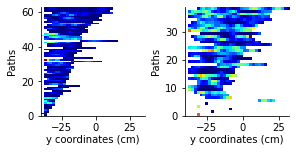

In [15]:
nRows=1
nCols=2
axesRowSize,axesColSize = 2,2
fig = plt.figure(figsize=(nCols*axesColSize,nRows*axesRowSize), constrained_layout=True) # figsize = (width,height)
spec = fig.add_gridspec(nrows=nRows,ncols=nCols) # create a GridSpec object to a figure
ax = fig.add_subplot(spec[0])  

plotTrialIFRMatrix(ax,m1,sort=True)

ax = fig.add_subplot(spec[1])
plotTrialIFRMatrix(ax,m2,sort=True)

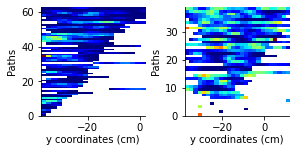

In [16]:
fig = plt.figure(figsize=(nCols*axesColSize,nRows*axesRowSize), constrained_layout=True) # figsize = (width,height)
spec = fig.add_gridspec(nrows=nRows,ncols=nCols) # create a GridSpec object to a figure

ax = fig.add_subplot(spec[0])  

m = removeEmptyTrials(m1)
m = trimTrailingMatrixNanColumn(m)
m = cutExtremelyLongTrials(m)
m1 = removeEmptyColumnsAtBeginning(m)

plotTrialIFRMatrix(ax,m1,sort=True)

ax = fig.add_subplot(spec[1])

m = removeEmptyTrials(m2)
m = trimTrailingMatrixNanColumn(m)
m = cutExtremelyLongTrials(m)
m2 = removeEmptyColumnsAtBeginning(m)

plotTrialIFRMatrix(ax,m2,sort=True)

The super long trials have been cut so that we always have a few data points per column.

In [17]:
from scipy.stats import skew

def trialMatrixDescriptiveStats(matDict):
    """
    Function that calculate statistics that describe a trial matrix
    """
    #print(matDict["cluId"],matDict["pathType"],matDict["light"],matDict["var"])
    matDict = trimTrailingMatrixNanColumn(matDict)
    matDict = removeEmptyTrials(matDict)
    matDict = cutExtremelyLongTrials(matDict,minNumberValidValues=20)
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    steps = bins[1]-bins[0]
    midBins = bins[:-1]+steps/2
    
    
    meanRate = np.nanmean(m)
    maxRate = np.nanmax(m)
    meanRateHisto = np.nanmean(m,axis = 0)
    #print(meanRateHisto)
    maxRateInHisto = np.nanmax(meanRateHisto)
    maxRateInHistoIndex = np.argmax(meanRateHisto)
    maxRateInHistoLoc = midBins[maxRateInHistoIndex]
    stdAtPeak = np.nanstd(m[:,maxRateInHistoIndex])
    # calculate the skewness of the rate values in the matrix, matrix with a clear peak with have a high sckewness
    a = m.reshape((1,-1))
    a = a [~np.isnan(a)]
    rateSkew = skew(a)
    return pd.DataFrame({"cluId": matDict["cluId"],
                         "pathType": matDict["pathType"],
                         "light": matDict["light"],
                         "behavioralVariable": matDict["var"],
                         "meanRate":[meanRate],
                         "maxRate":maxRate, 
                         "maxRateInHisto":maxRateInHisto, 
                         "maxRateInHistoLoc":maxRateInHistoLoc, 
                         "stdAtPeak":stdAtPeak, 
                         "rateSkew":rateSkew})
    

In [18]:
trialMatrixDescriptiveStats(m1)

,cluId,pathType,light,behavioralVariable,meanRate,maxRate,maxRateInHisto,maxRateInHistoLoc,stdAtPeak,rateSkew
0,mn3246-09042021-0106_4,homingFromLeavingLeverToPeriphery,light,y,6.47585,68.651757,8.173273,-37.0,12.789001,2.015553


In [19]:
trialMatrixDescriptiveStats(m2)

,cluId,pathType,light,behavioralVariable,meanRate,maxRate,maxRateInHisto,maxRateInHistoLoc,stdAtPeak,rateSkew
0,mn711-01022021-0107_41,homingFromLeavingLeverToPeriphery,dark,y,6.27608,23.421937,8.087083,-31.0,5.376892,0.729576


We create a data frame that contains the statistics of the trial matrices.

In [20]:
myHomingDict["mn711-01022021-0107_117"]["matrix"].keys()

dict_keys(['homingFromLeavingLeverToPeriphery_light_iTime', 'homingFromLeavingLeverToPeriphery_dark_iTime', 'homingFromLeavingLeverToPeriphery_light_distance', 'homingFromLeavingLeverToPeriphery_dark_distance', 'homingFromLeavingLeverToPeriphery_light_targetDistance', 'homingFromLeavingLeverToPeriphery_dark_targetDistance', 'homingFromLeavingLeverToPeriphery_light_y', 'homingFromLeavingLeverToPeriphery_dark_y'])

In [21]:
myList = []
for myDict,path in zip([mySearchDict,myHomingDict],["searchToLeverPath","homingFromLeavingLeverToPeriphery"]):
    for var in ["y","distance","iTime","targetDistance"]:
        for light in ["light","dark"]:
            df = pd.concat([ trialMatrixDescriptiveStats(get_matDic(myDict,cluId=cluId,pathType = path, light =light, var = var)) for cluId in mySearchDict.keys()])
            myList.append(df)
tmStats = pd.concat(myList)

/tmp/ipykernel_51818/3252121336.py:20: RuntimeWarning: Mean of empty slice
  meanRateHisto = np.nanmean(m,axis = 0)
/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [22]:
tmStats

,cluId,pathType,light,behavioralVariable,meanRate,maxRate,maxRateInHisto,maxRateInHistoLoc,stdAtPeak,rateSkew
0,mn5824-20112020-0107_92,searchToLeverPath,light,y,14.493111,103.996836,19.342487,5.0,24.534880,1.790586
0,mn5824-20112020-0107_100,searchToLeverPath,light,y,0.733515,33.873356,1.085109,-17.0,4.188464,6.176024
0,mn5824-20112020-0107_114,searchToLeverPath,light,y,2.231578,58.287972,4.269781,-17.0,11.957404,4.506404
0,mn5824-20112020-0107_116,searchToLeverPath,light,y,0.052177,11.526491,0.157100,-33.0,1.313242,15.110985
0,mn5824-20112020-0107_118,searchToLeverPath,light,y,0.037693,6.938737,0.208342,-39.0,1.047773,12.785876
...,...,...,...,...,...,...,...,...,...,...
0,mn9686-01112021-0106_79,homingFromLeavingLeverToPeriphery,dark,targetDistance,0.479645,23.501198,0.847731,19.0,3.427651,5.985001
0,mn9686-01112021-0106_81,homingFromLeavingLeverToPeriphery,dark,targetDistance,0.003338,1.338997,0.018095,13.0,0.154600,20.558974
0,mn9686-01112021-0106_197,homingFromLeavingLeverToPeriphery,dark,targetDistance,0.311009,45.921147,0.852285,19.0,5.807949,12.393413
0,mn9686-01112021-0106_242,homingFromLeavingLeverToPeriphery,dark,targetDistance,2.274357,26.863913,5.034981,37.0,7.257069,2.745090


In [23]:
fn=myProject.dataPath+"/results/trialMatrixStats.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(tmStats, handle)

saving: /adata/projects/autopi_ca1/results/trialMatrixStats.pickle


## Trial matrix correlation

We need a way to quantify the reliability of the information in the firing rate of the neuron across trials. We can measure this by calculating the correlation matrix of the **trial rate matrix**.

Each row of the **trial rate matrix** has the rate as a function of distance, time, y-coordinate or target distance. We can correlate all pairs of rows to measure how reliable the rate information is across trials.

That can be used to quantify how well information is encoded in the trial matrix, and compare different conditions.


We have a problem with the np.nan in the matrix. We need to consider only values for which both trials have valid values. This means we can't use `np.corrcoef()`. 

We are going to use the code quite a lot so we use Numba to compile to C language.

In [24]:
from numba import jit
import datetime 

@jit()
def rollARow(a):
    """
    Function to roll the firing rate value of a single trial (one row)

    Only rolls the bins from first to last valid entries in the array
    
    The amount of shift is random
    """
    
    if np.sum(~np.isnan(a)) == 0:
        return a
    lastVal = np.where(~np.isnan(a))[0].max()
    firstVal = np.where(~np.isnan(a))[0].min()
    myRange = lastVal-firstVal
    A = a.copy()
    if myRange > 2:
        shift = np.random.randint(low = 0, high=myRange, size=1)[0]
        b = a[firstVal:(lastVal+1)]
        b = np.roll(b,shift)
        A[firstVal:lastVal+1] = b 
    return A


def shuffledTrialMap(m):
    return np.apply_along_axis(rollARow,axis=1,arr=m)


@jit()
def myOwnCorr(x,y,valx,valy):
    """
    Perform pearson correlation on 2 1D arrays, 
    It removes observations with np.nan
    """

    # keep only observations without np.nan
    indices= valx&valy
    #print("valid:",np.sum(indices))
    xx = x[indices]
    yy = y[indices]
    
    if np.sum(indices) < 2:
        return np.nan
    if np.all(xx==0):
        return np.nan
    if np.all(yy==0):
        return np.nan   
    else :
        return np.corrcoef(xx,yy)[0,1]
    


@jit()
def trialMatrixInternalCorrelation(m):
    """
    Calculate the mean of the correlation matrix (one half) of a matrix m, excluding the diagonal
    """
    # check which values are valid only once and not in the loops
    val = ~np.isnan(m)
    
    dim = m.shape[0]
    res = np.zeros(int(dim*(dim-1)/2)) # number of unique pairs of trials
    count = 0
    for i in range(dim):
        for j in range(i+1,dim):
            res[count] = myOwnCorr(m[i],m[j],val[i],val[j])
            count+=1
    return np.nanmean(res)


def trialMatrixInternalCorrelationShuffle(m,nShuf=10):
    """
    Calculate the mean of the correlation matrix (one half) of matrix m with matrix n, excluding the diagonal
    
    n is generated by shifting the rate values within each trial, keeping sequence but moving it forwards or backwards
    """
    resShuf = np.empty(nShuf) # to store results

    # check which values are valid only once and not in the loops
    valm = ~np.isnan(m)
    dim = m.shape[0]
    res = np.zeros(int(dim*(dim-1)/2)) # for all pairs of trials

    for x in range(nShuf):
        n = shuffledTrialMap(m)
        valn = ~np.isnan(n)
        
        count = 0
        for i in range(dim):
            for j in range(i+1,dim):
                res[count] = myOwnCorr(m[i],n[j],valm[i],valn[j])
                count+=1
        resShuf[x] = np.nanmean(res)
            
    return resShuf



Calculate for all our trial matrices.

In [25]:
%%time
trialMatrixCor = pd.DataFrame()
for path in [ "searchToLeverPath","homingFromLeavingLeverToPeriphery"]:
    if path == "searchToLeverPath":
        myDict = mySearchDict
    else:
        myDict = myHomingDict
        
    for light in ["light","dark"]:
        for var in ["distance","iTime","targetDistance","y"]:
            cor = [trialMatrixInternalCorrelation(myDict[cluId]["matrix"]["{}_{}_{}".format(path,light,var)]["matrix"]) for cluId in list(myDict.keys())]
            
            df = pd.DataFrame({"cluId": list(mySearchDict.keys()),
                               "path": path,
                               "light":light,
                               "var": var,
                               "cor":cor,})
            trialMatrixCor = trialMatrixCor.append(df)
                          

CPU times: user 16.8 s, sys: 8.36 ms, total: 16.9 s
Wall time: 16.9 s


In [26]:
trialMatrixCor

,cluId,path,light,var,cor
0,mn5824-20112020-0107_92,searchToLeverPath,light,distance,0.034151
1,mn5824-20112020-0107_100,searchToLeverPath,light,distance,0.016818
2,mn5824-20112020-0107_114,searchToLeverPath,light,distance,0.009486
3,mn5824-20112020-0107_116,searchToLeverPath,light,distance,0.141073
4,mn5824-20112020-0107_118,searchToLeverPath,light,distance,0.152111
...,...,...,...,...,...
433,mn9686-01112021-0106_79,homingFromLeavingLeverToPeriphery,dark,y,0.156115
434,mn9686-01112021-0106_81,homingFromLeavingLeverToPeriphery,dark,y,NaN
435,mn9686-01112021-0106_197,homingFromLeavingLeverToPeriphery,dark,y,0.281917
436,mn9686-01112021-0106_242,homingFromLeavingLeverToPeriphery,dark,y,0.098194


In [27]:
fn = fn=myProject.dataPath+"/results/trialMatrixCor.csv"
print("saving to",fn,datetime.datetime.now())
trialMatrixCor.to_csv(fn)

saving to /adata/projects/autopi_ca1/results/trialMatrixCor.csv 2022-09-01 10:01:13.605178


We want to get a shuffle distribution for these scores.

The only difference in the shuffle is that we shift the data of each trial by a random amount.

In [28]:
%%time
nShuf= 500
trialMatrixCorShuf = pd.DataFrame()

for path in [ "searchToLeverPath","homingFromLeavingLeverToPeriphery"]:
    if path == "searchToLeverPath":
        myDict = mySearchDict
    else:
        myDict = myHomingDict
    for light in ["light","dark"]:
        for var in ["distance","iTime","targetDistance","y"]:
            for cluId in tqdm(list(myDict.keys())):
                #print(path,light,var,cluId)
                m = myDict[cluId]["matrix"]["{}_{}_{}".format(path,light,var)]["matrix"]
                cor = trialMatrixInternalCorrelationShuffle(m,nShuf)
                df = pd.DataFrame({"cluId": cluId,
                                   "path": path,
                                   "light":light,
                                   "var": var,
                                   "cor":cor})
                trialMatrixCorShuf = trialMatrixCorShuf.append(df)


  3%|█▍                                        | 15/438 [00:29<11:32,  1.64s/it]/tmp/ipykernel_51818/3442990545.py:96: RuntimeWarning: Mean of empty slice
  resShuf[x] = np.nanmean(res)
100%|█████████████████████████████████████████| 438/438 [10:17<00:00,  1.41s/it]

CPU times: user 3h 2min 54s, sys: 1min 46s, total: 3h 4min 41s
Wall time: 3h 4min 35s


In [29]:
fn = fn=myProject.dataPath+"/results/trialMatrixCorShuf.csv"
print("saving to",fn,datetime.datetime.now())
trialMatrixCorShuf.to_csv(fn)

saving to /adata/projects/autopi_ca1/results/trialMatrixCorShuf.csv 2022-09-01 13:05:49.239338


### Significance table
Create a data frame to know which trial matrix internal correlations are significant.

In [30]:
def trialMatricInternalCorrelationSignificant(cluId,light,pathType,var):
    df = trialMatrixCor    
    condIndex = (df["cluId"]==cluId)&(df["light"]==light)&(df["path"]==pathType)&(df["var"]==var)
    obsR = df[condIndex].cor.iloc[0]
    df = trialMatrixCorShuf
    condIndex = (df["cluId"]==cluId)&(df["light"]==light)&(df["path"]==pathType)&(df["var"]==var)
    shufR = df[condIndex].cor
    highSignLevel = np.percentile(shufR,99.0)
    if obsR > highSignLevel:
        return True
    else:
        return False

significantMatrix = pd.DataFrame({"cluId":pyrId})
for light in ["light","dark"]:
    for pathType in ["homingFromLeavingLeverToPeriphery", "searchToLeverPath"]:
        for var in ["y","targetDistance"]:
            significantMatrix["{}-{}-{}".format(pathType,light,var)] = [ trialMatricInternalCorrelationSignificant(cluId,light,pathType,var=var) for cluId in tqdm(pyrId) ]

            

100%|█████████████████████████████████████████| 438/438 [03:03<00:00,  2.39it/s]


In [31]:
fn = fn=myProject.dataPath+"/results/trialMatrixSign.csv"
print("saving to",fn)
significantMatrix.to_csv(fn)

saving to /adata/projects/autopi_ca1/results/trialMatrixSign.csv


# Correlation between trial matrix peaks and lever location

We want to test whether a neuron encodes information about the distance to the lever.

We can test if the neuron fires at a fixed location from the lever. One way to test this is to consider the trial matrix with the firing rate as a function of y-position. For each trial we can get the y-position of the lever. If the neuron encodes the distance to the lever, there should be a positive correlation between the location of the peak rate and the location of the lever.

We can look at this type of coding during homing. We need to use only trials with accurate homing.



In [1]:
%%time
%load_ext autoreload
%autoreload 2
%run setup_project.py

myProjectWithTrials = loadMyProjectWithTrials(myProject)
prepareSessionsForSpatialAnalysisProject(sSesList,myProjectWithTrials.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading: /adata/projects/autopi_ca1/results/myProjectWithTrials.pickle
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|█████████████████████████████████████████████████████████████████| 39/39 [00:52<00:00,  1.36s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict
CPU times: user 18.1 s, sys: 31.5 s, total: 49.6 s
Wall time: 2min 17s


In [7]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from numba import jit
import datetime 

@jit()
def myOwnCorr2(x,y):
    """
    This one assumes that there are no np.nan
    """
    if np.all(x==0):
        return np.nan
    if np.all(y==0):
        return np.nan   
    else :
        return np.corrcoef(x,y)[0,1]

def peakPositionLeverPositionCorrelation(cluId,light="light",pathType="searchToLeverPath",coordX="y",nShuf=100):

    sessionName = cluId.split("_")[0]
    ses = myProjectWithTrials.sessionList[[ses.name == sessionName for ses in myProjectWithTrials.sessionList].index(True)]
    ifr, navs, inav = load_ifr_behavior(ses)
    navsSel = navs[(navs.type==pathType) & (navs.light==light)]
    trialDf = ses.getTrialVariablesDataFrame()
    navsSel = pd.merge(navsSel,trialDf,on = "trialNo")
    #print("navsSel shape:",navsSel.shape)
    navsSel
    
    # get the original trial map
    if pathType == "searchToLeverPath":
        myDict = mySearchDict
    else:
        myDict = myHomingDict
        
    m = myDict[cluId]["matrix"][pathType+"_"+light+"_"+coordX]["matrix"].copy()
    nTrials = m.shape[0]
    
    if m.shape[0] != navsSel.shape[0]:
        print("m and navsSel shapes do not match {} {}".format(m.shape[0],navsSel.shape[0]))

   
    
    # cut the matrix so that the trials ends at the longest trial of this type
    nBins = m.shape[1]
    minIndex = np.where(~np.all(np.isnan(m),axis=0))[0].min() # first column with valid value
    maxIndex = np.where(~np.all(np.isnan(m),axis=0))[0].max() # last column with valid value
    
    m = m[:,minIndex:maxIndex+1]
    nBinsKept = m.shape[1]
    
    # trial selection if needed
    trialToKeep = ~np.all(np.isnan(m),axis=1) # remove a trial if all firing rate values are np.nan
    trialToKeep = np.logical_and(np.abs(navsSel.homingErrorAtPeriphery) < (np.pi/4),trialToKeep)   # this should give 90 degree range centered on the home base
    
    #print("Keeping {} of {} trials, {} of {} bins".format(np.sum(trialToKeep),nTrials,nBinsKept,nBins))
   
    # get the firing rate peak location for each trial
    m = m[trialToKeep]
    peakLoc = np.nanargmax(m,axis=1)*2 # *2 because every bin is 2 cm

    # get the y lever position
    leverY= navsSel.leverY.to_numpy()[trialToKeep]

    r = myOwnCorr2(leverY,peakLoc)
    model = LinearRegression()
    model.fit(leverY.reshape(-1,1),peakLoc)
    inter = model.intercept_
    slope = model.coef_[0]
    
    df = pd.DataFrame({"cluId":[cluId],
                      "light":[light],
                      "pathType":[pathType],
                       "coordX": coordX,
                       "shuf": [False],
                      "cor": [r],
                      "slope": slope,
                      "intercept": inter})
    
    shufRes = np.empty((nShuf,3))
    for i in range(nShuf):
        shufM=shuffledTrialMap(m)
        peakLoc = np.nanargmax(shufM,axis=1)*2 # *2 because every bin is 2 cm
        
        shufRes[i,0] = myOwnCorr2(leverY,peakLoc)
        model.fit(leverY.reshape(-1,1),peakLoc)
        shufRes[i,1] = model.intercept_
        shufRes[i,2] = model.coef_[0]
    
    
    dfShuf = pd.DataFrame({"cluId":cluId,
                      "light":light,
                      "pathType":pathType,
                           "coordX":coordX,
                       "shuf": True,
                      "cor": shufRes[:,0],
                       "slope": shufRes[:,2],
                        "intercept": shufRes[:,1]})
    df = df.append(dfShuf)
    
    return df

1 33
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


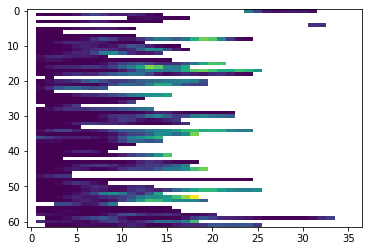

In [8]:
cluId = "mn5824-22112020-0107_110"
light="light"
pathType="homingFromLeavingLeverToPeriphery"
coordX="y"

m = myHomingDict[cluId]["matrix"][pathType+"_"+light+"_"+coordX]["matrix"].copy()

plt.imshow(m,aspect="auto",interpolation="none")

#cut the matrix so that the trials ends at the longest trial of this type
minIndex = np.where(~np.all(np.isnan(m),axis=0))[0].min() # first column with valid value
maxIndex = np.where(~np.all(np.isnan(m),axis=0))[0].max() # last column with valid value
print(minIndex,maxIndex)
print(~np.all(np.isnan(m),axis=0)[minIndex:maxIndex+1])

In [9]:
~np.all(np.isnan(m),axis=0)


#maxValIndex = np.max(np.argmax(np.isnan(m),axis=1))
#np.argmax(np.isnan(m),axis=1)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False])

In [10]:
%%time
cluId = "mn5824-22112020-0107_110" #pyrId.iloc[1]
peakPositionLeverPositionCorrelation(cluId=cluId,light="light",pathType="homingFromLeavingLeverToPeriphery",coordX="y",nShuf=500)

CPU times: user 5.22 s, sys: 139 ms, total: 5.36 s
Wall time: 5.85 s


,cluId,light,pathType,coordX,shuf,cor,slope,intercept
0,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,False,0.734094,0.774265,16.882426
0,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.445414,0.349727,10.879394
1,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.433387,0.345262,10.665769
2,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.486407,0.405090,9.659248
3,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.580721,0.556943,11.649704
...,...,...,...,...,...,...,...,...
495,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.612212,0.574281,13.341098
496,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.560430,0.485394,11.904552
497,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.440699,0.378571,12.049952
498,mn5824-22112020-0107_110,light,homingFromLeavingLeverToPeriphery,y,True,0.582344,0.599881,11.896786


In [11]:
%%time
df = pd.DataFrame()
for pathType in ["homingFromLeavingLeverToPeriphery", "searchToLeverPath"]:
    for light in ["dark","light"]:
        for cluId in tqdm(mySearchDict.keys()):
            df = df.append(peakPositionLeverPositionCorrelation(cluId=cluId,light=light,pathType=pathType,coordX="y",nShuf=500))

100%|███████████████████████████████████████████████████████████████| 438/438 [04:44<00:00,  1.54it/s]

CPU times: user 17min 56s, sys: 1min 3s, total: 18min 59s
Wall time: 19min 14s


2004

In [19]:
fn = fn=myProject.dataPath+"/results/peakPositionLeverPositionCorr.csv"
print("saving to",fn,datetime.datetime.now())
df.to_csv(fn)

saving to /adata/projects/autopi_ca1/results/peakPositionLeverPositionCorr.csv 2022-09-08 10:33:39.199066


Now create a data frame to indicate which neuron has significant lever peak loc lever loc correlation

In [20]:
import pandas as pd
fn = fn=myProject.dataPath+"/results/peakPositionLeverPositionCorr.csv"
peakPositionLeverPositionCorr = pd.read_csv(fn)

In [21]:
def peakPositionLeverPositionCorrSignificant(cluId,light,pathType):
    
    df = peakPositionLeverPositionCorr
    df = peakPositionLeverPositionCorr
    condIndex = (df["cluId"]==cluId)&(df["light"]==light)&(df["pathType"]==pathType)&(df["shuf"]==False)
    obsR = df[condIndex].cor.iloc[0]
    condIndex = (df["cluId"]==cluId)&(df["light"]==light)&(df["pathType"]==pathType)&(df["shuf"]==True)
    shufR = df[condIndex].cor
    highSignLevel = np.percentile(shufR,95.0)
    if obsR > highSignLevel:
        return True
    else:
        return False

significantLever = pd.DataFrame({"cluId":pyrId})
for light in ["light","dark"]:
    for pathType in ["homingFromLeavingLeverToPeriphery", "searchToLeverPath"]:
        print(light,pathType)
        significantLever["{}-{}".format(pathType,light)] = [ peakPositionLeverPositionCorrSignificant(cluId,light,pathType) for cluId in tqdm(pyrId) ]

light homingFromLeavingLeverToPeriphery


100%|███████████████████████████████████████████████████████████████| 438/438 [01:18<00:00,  5.57it/s]


light searchToLeverPath


100%|███████████████████████████████████████████████████████████████| 438/438 [01:19<00:00,  5.54it/s]


dark homingFromLeavingLeverToPeriphery


100%|███████████████████████████████████████████████████████████████| 438/438 [01:18<00:00,  5.59it/s]


dark searchToLeverPath


100%|███████████████████████████████████████████████████████████████| 438/438 [01:21<00:00,  5.40it/s]


In [22]:
fn = fn=myProject.dataPath+"/results/leverPeakCorrSign.csv"
print("saving to",fn)
significantLever.to_csv(fn)

saving to /adata/projects/autopi_ca1/results/leverPeakCorrSign.csv
